In [1]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import classify_north_south

idx = pd.IndexSlice

In [42]:
# day = '2022-01-03'
day = 'total'

In [53]:
if day != 'total':
    cost_summary = pd.read_csv(
        Path.cwd().parent / 'results' / f'{day}' / 'system_cost_summary_flex.csv', 
        index_col=[0,1],
        parse_dates=[0]
        )
else:
    cost_summary = pd.read_csv(
        Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', 
        index_col=[0,1],
        parse_dates=[0]
        )

index = cost_summary.index.get_level_values(0).unique()

cost_summary.head()

nodal     zonal  national
2022-01-01 wholesale        0.803885  0.839295  0.908435
           congestion_rent -0.302112 -0.308730  0.000000
           cfd_payments     0.133109  0.128072  0.144613
           roc_payments     0.419723  0.419723  0.426495
           offer_cost       0.000000  0.000102  0.135881

In [55]:
# rev_path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')
if day != 'total':
    rev_path = str(Path.cwd().parent / 'results' / f'{day}' / 'bmu_revenues_flex_{}.csv')
    unit_scaling = 1e-6
else:
    rev_path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')
    unit_scaling = 1e-9

rev_national = pd.read_csv(rev_path.format('national'), index_col=0, header=[0,1,2], parse_dates=True).loc[index].sum().mul(unit_scaling)
rev_zonal = pd.read_csv(rev_path.format('zonal'), index_col=0, header=[0,1,2], parse_dates=True).loc[index].sum().mul(unit_scaling)

In [56]:
rev_national = pd.concat((
    rev_national.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_national.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))
rev_zonal = pd.concat((
    rev_zonal.loc[idx[:, ['wind', 'disp', 'hydro', 'storage'], :]],
    pd.Series(rev_zonal.loc[idx[:, 'intercon', :]].sum(), index=pd.MultiIndex.from_tuples([('total', 'interconnector', 'wholesale')]))
))

In [57]:
if day != 'total':
    mp = pd.read_csv(
        Path.cwd().parent / 'results' / f'{day}' / 'marginal_prices_flex.csv',
        index_col=0,
        parse_dates=[0],
        header=[0,1]
        )
else:
    mp = pd.read_csv(
        Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv',
        index_col=0,
        parse_dates=[0],
        header=[0,1]
        )

mp = mp.loc[index]

In [58]:
idx = pd.IndexSlice
buses = mp.loc[:,idx['zonal',:]].columns.get_level_values(1)

In [59]:
weights = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)

weights = weights.loc[buses.astype(int)]
weights /= weights.sum()

In [60]:
if day != 'total':
    load = pd.read_csv(
        Path.cwd().parent / 'results' / f'{day}' / 'gb_total_load_flex.csv',
        index_col=0,
        parse_dates=[0]
    ).rename(columns={'0': 'load'})
else:
    load = pd.read_csv(
        Path.cwd().parent / 'summaries' / 'total_gb_load.csv',
        index_col=0,
        parse_dates=[0]
    ).rename(columns={'0': 'load'})

load = pd.DataFrame(
    np.outer(load.values, weights.values),
    index=load.index,
    columns=weights.index.astype(str)
    ).loc[index]

load.head()

Bus,8838,8013,8649,4950,4951,4952,4953,4955,4956,4958,...,8021,8578,7469,8027,8016,8019,7458,8283,8093,7908
2022-01-01 00:00:00,82.212111,8.340387,129.346981,101.994368,92.374920,91.738895,90.450479,81.018378,139.559235,68.225588,...,118.334611,138.653210,15.893912,71.930969,92.713012,2.485248,45.402299,177.479751,129.246211,96.547129
2022-01-01 00:30:00,82.688185,8.388684,130.096002,102.584996,92.909844,92.270136,90.974259,81.487539,140.367393,68.620668,...,119.019863,139.456122,15.985950,72.347506,93.249894,2.499640,45.665214,178.507499,129.994649,97.106213
2022-01-01 01:00:00,82.728537,8.392778,130.159490,102.635059,92.955185,92.315165,91.018655,81.527305,140.435894,68.654156,...,119.077946,139.524178,15.993751,72.382813,93.295401,2.500859,45.687499,178.594613,130.058088,97.153602
2022-01-01 01:30:00,83.905490,8.512180,132.011228,104.095215,94.277629,93.628504,92.313549,82.687169,142.433831,69.630877,...,120.772030,141.509145,16.221289,73.412580,94.622685,2.536438,46.337481,181.135422,131.908383,98.535776
2022-01-01 02:00:00,78.634947,7.977485,123.718911,97.556449,88.355557,87.747207,86.514851,77.493154,133.486816,65.256996,...,113.185706,132.620214,15.202345,68.801151,88.678938,2.377111,43.426781,169.757357,123.622526,92.346227


In [61]:
network = pypsa.Network(
    # Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_nodal.nc'
    Path.cwd().parent / 'results' / '2024-03-24' / 'network_flex_s_nodal.nc'
)

buses = network.buses[['x', 'y']]
buses.loc[:, ['region']] = buses.apply(lambda x: classify_north_south(x['x'], x['y']), axis=1)

INFO:pypsa.io:Imported network network_flex_s_nodal.nc has buses, carriers, generators, links, loads, storage_units


In [62]:
north_loads = load.loc[:, buses.loc[buses.region == 'north'].index]
south_loads = load.loc[:, buses.loc[buses.region == 'south'].index.intersection(load.columns)]

print(north_loads.shape)
print(south_loads.shape)

(51360, 60)
(51360, 224)


In [82]:
import warnings
warnings.filterwarnings('ignore')

def get_wholesale_costs(mp, loads, mode):

    idx = pd.IndexSlice

    if mode == 'national':
        return np.inner(
            loads.sum(axis=1).values,
            mp.loc[:,idx['national', 'GB']].values
            ) * 0.5
        
    elif mode == 'zonal':
        total = 0
        for col in loads.columns:
            total += np.inner(
                loads.loc[:,col].values,
                mp.loc[:,idx['zonal', col]].values
                )
        return total * 0.5


costs = pd.Series(0, # is in units M£
    index=pd.MultiIndex.from_product([
        ['wholesale'],
        ['north', 'south'],
        ['national', 'zonal']
        ]
    ).append(
        pd.MultiIndex.from_product([
            ['roc', 'cfd', 'bids', 'offers', 'cfd'],
            ['socialised'],
            ['national', 'zonal']
            ]
        )
    )
)

costs.loc[idx['wholesale', 'north', 'national']] = get_wholesale_costs(mp, north_loads, 'national') * unit_scaling
costs.loc[idx['wholesale', 'south', 'national']] = get_wholesale_costs(mp, south_loads, 'national') * unit_scaling
costs.loc[idx['wholesale', 'north', 'zonal']] = get_wholesale_costs(mp, north_loads, 'zonal') * unit_scaling
costs.loc[idx['wholesale', 'south', 'zonal']] = get_wholesale_costs(mp, south_loads, 'zonal') * unit_scaling

costs.loc[idx['roc', 'socialised', 'national']] = cost_summary.loc[idx[:, 'roc_payments'], 'national'].sum() * 1e6 * unit_scaling
costs.loc[idx['cfd', 'socialised', 'national']] = cost_summary.loc[idx[:, 'cfd_payments'], 'national'].sum() * 1e6 * unit_scaling
costs.loc[idx['bids', 'socialised', 'national']] = cost_summary.loc[idx[:, 'bid_cost'], 'national'].sum() * 1e6 * unit_scaling
costs.loc[idx['offers', 'socialised', 'national']] = cost_summary.loc[idx[:, 'offer_cost'], 'national'].sum() * 1e6 * unit_scaling
costs.loc[idx['congestion_rent', 'socialised', 'national']] = cost_summary.loc[idx[:, 'congestion_rent'], 'national'].sum() * 1e6 * unit_scaling

costs.loc[idx['roc', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'roc_payments'], 'zonal'].sum() * 1e6 * unit_scaling
costs.loc[idx['cfd', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'cfd_payments'], 'zonal'].sum() * 1e6 * unit_scaling
costs.loc[idx['bids', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'bid_cost'], 'zonal'].sum() * 1e6 * unit_scaling
costs.loc[idx['offers', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'offer_cost'], 'zonal'].sum() * 1e6 * unit_scaling
costs.loc[idx['congestion_rent', 'socialised', 'zonal']] = cost_summary.loc[idx[:, 'congestion_rent'], 'zonal'].sum() * 1e6 * unit_scaling

costs

wholesale        north       national     3.233213
                             zonal        2.481685
                 south       national    95.170288
                             zonal       96.558620
roc              socialised  national    13.905332
                             zonal       13.961020
cfd              socialised  national     1.969155
                             zonal        1.949835
bids             socialised  national     0.328954
                             zonal       -0.051858
offers           socialised  national     3.095382
                             zonal        0.476999
cfd              socialised  national     1.969155
                             zonal        1.949835
congestion_rent  socialised  national     0.000000
                             zonal       -4.412838
dtype: float64

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon

def create_curved_polygon(start, end, height, width, resolution=30):

    x0, y0 = start
    x1, y1 = end

    left_radius = (height - y0) / 2
    right_radius = (height - y1) / 2

    # --- Left Half-Circle Arc ---
    left_center = (x0, y0 + left_radius)
    angles_left = np.linspace(-np.pi/2, np.pi/2, resolution)
    left_arc = [
        (left_center[0] - left_radius * np.cos(theta), left_center[1] + left_radius * np.sin(theta))
        for theta in angles_left
    ]

    # --- Horizontal Segment ---
    horizontal_xs = np.linspace(x0, x1, resolution)
    horizontal_segment = [(x, height) for x in horizontal_xs]

    # --- Right Half-Circle Arc ---
    right_center = (x1, y1 + right_radius)
    angles_right = np.linspace(np.pi/2, -np.pi/2, resolution)
    right_arc = [
        (right_center[0] + right_radius * np.cos(theta), right_center[1] + right_radius * np.sin(theta))
        for theta in angles_right
    ]

    # --- Combine the Upper Curve ---
    upper_curve = left_arc + horizontal_segment + right_arc

    # Create a LineString from the upper curve and then buffer it to get the full polygon.
    line = LineString(upper_curve)
    polygon = line.buffer(width/2)

    left_removal = Polygon([
        (x0, y0 + width/2),
        (x0, y0 - width/2),
        (x0 + width/2, y0 - width/2),
        (x0 + width/2, y0 + width/2),
    ])
    right_removal = Polygon([
        (x1, y1 + width/2),
        (x1, y1 - width/2),
        (x1 - width/2, y1 - width/2),
        (x1 - width/2, y1 + width/2),
    ])

    return polygon.difference(right_removal).difference(left_removal)

In [111]:
def get_positive_cost_total(costs, mode):
    part1 = costs.loc[idx['wholesale', 'north', mode]].sum()
    part2 = costs.loc[idx['wholesale', 'south', mode]].sum()

    ss = costs.loc[idx[:, 'socialised', mode]]
    part3 = ss.loc[ss > 0].sum()

    return part1 + part2 + part3

In [134]:
def get_consumer_box_limits(costs, mode, gap):

    box1 = costs.loc[idx['wholesale', 'north', mode]].sum()
    box2 = costs.loc[idx['wholesale', 'south', mode]].sum()

    ss = costs.loc[idx[:, 'socialised', mode]]
    box3 = ss.loc[ss > 0].sum()

    total = box1 + box2 + box3

    box1 = box1 / total
    box2 = box2 / total
    box3 = box3 / total

    box1_upper = 1
    box1_lower = box1_upper - box1

    box2_upper = box1_lower - gap
    box2_lower = box2_upper - box2

    box3_upper = box2_lower - gap
    
    box3_lower = box3_upper - box3

    if mode == 'zonal':
        box3_lower = box3_lower - abs(costs.loc[idx['congestion_rent', :, mode]].sum()) / total

    return (
        (box1_upper, box1_lower),
        (box2_upper, box2_lower),
        (box3_upper, box3_lower)
    )


gap = 0.02
box_width = 0.03
left_end = 0.
right_end = 1.

In [135]:
get_consumer_box_limits(costs, 'zonal', gap)

((1, 0.9788573207296376),
 (0.9588573207296376, 0.13622765519343893),
 (0.11622765519343893, -0.07759510827981281))

In [121]:
def get_generator_box_limits(revs, gap):

    box_heights = {}

    revs = revs.copy() / revs.sum()

    for region, carrier in zip(revs.index.get_level_values(0), revs.index.get_level_values(1)):

        box_heights[(region, carrier)] = revs.loc[idx[region, carrier, :]].sum()

    box_upper = {}
    box_lower = {}

    # Sort by region first, then carrier
    sorted_items = sorted(box_heights.keys(), key=lambda x: (x[0], x[1]))

    current_upper = 1
    for item in sorted_items:
        box_upper[item] = current_upper
        box_lower[item] = current_upper - box_heights[item]
        current_upper = box_lower[item] - gap

    # Handle interconnector separately since it's in 'total' region
    box_upper[('total', 'interconnector')] = current_upper
    box_lower[('total', 'interconnector')] = current_upper - box_heights[('total', 'interconnector')]

    return box_lower, box_upper


In [122]:
# Helper function to draw curved flow paths
def bezier_path(start, end, turning_ratio, num_samples=100):
    """
    Creates a smooth cubic Bézier curve as a NumPy array of points,
    suitable for use in Sankey diagrams.

    Parameters:
        start (tuple or list): (x, y) coordinates for the starting point.
        end (tuple or list): (x, y) coordinates for the ending point.
        turning_ratio (float): A value between 0 and 1 that defines the x-position
                               of the turning point. A value of 0 means the turning
                               point is at the start's x-coordinate, while 1 is at the end's.
        num_samples (int): The number of points to sample along the curve.

    Returns:
        numpy.ndarray: An array of shape (num_samples, 2) with the (x, y) coordinates of the curve.
    """
    # Convert start and end to NumPy arrays
    start = np.array(start, dtype=float)
    end = np.array(end, dtype=float)
    
    # Compute the common x-coordinate for both control points based on turning_ratio
    cp_x = start[0] + turning_ratio * (end[0] - start[0])
    
    # Define control points
    cp1 = np.array([cp_x, start[1]])
    cp2 = np.array([cp_x, end[1]])
    
    # Create an array of parameter values t in [0, 1]
    t = np.linspace(0, 1, num_samples).reshape(-1, 1)  # shape (num_samples, 1)
    one_minus_t = 1 - t

    # Evaluate the cubic Bézier curve at each t using the formula:
    # B(t) = (1-t)^3 * P0 + 3*(1-t)^2*t * P1 + 3*(1-t)*t^2 * P2 + t^3 * P3
    curve = (one_minus_t**3) * start + \
            3 * (one_minus_t**2) * t * cp1 + \
            3 * one_minus_t * (t**2) * cp2 + \
            (t**3) * end

    return curve[:,0], curve[:,1]

In [123]:
class FlowStart:

    def __init__(self, upper_bound, lower_bound):
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.current_upper = upper_bound

    def __str__(self):
        return f"FlowStart(upper_bound={self.upper_bound:.4f}, lower_bound={self.lower_bound:.4f}, current_upper={self.current_upper:.4f})"

    def add_flow(self, flow):
        return_value = self.current_upper
        self.current_upper -= flow
        return return_value
    
    def __repr__(self):
        return self.__str__()
    

In [124]:
def reset_flowstarts(rev_lowers, rev_uppers):
    flowstarts = {}

    for block_name in ['con_n', 'con_s', 'soc']:
        block = globals()[block_name]
        flowstarts[block_name] = FlowStart(
            *block
            )

    for (name, upper), (name2, lower) in zip(rev_uppers.items(), rev_lowers.items()):
        assert name == name2
        flowstarts[name] = FlowStart(
            upper,
            lower
            )
    
    return flowstarts

In [125]:
def prepare_plot_data(mode):

    con_n, con_s, soc = get_consumer_box_limits(costs, mode, gap)

    rev = globals()[f'rev_{mode}']
    rev = rev.sort_index()

    rev_lowers, rev_uppers = get_generator_box_limits(rev, gap)
    rev_flows = rev.copy() / rev.abs().sum()

    return con_n, con_s, soc, rev_lowers, rev_uppers, rev_flows, rev.sum()

In [126]:
def get_largest_total():

    return max(
        globals()[f'rev_national'].sum(),
        globals()[f'rev_zonal'].sum(),
    )
    
get_largest_total()

99.73597032074521

In [127]:
color_mapper = {
    'roc': color_dict['roc_payments'],
    'cfd': color_dict['cfd_payments'],
    'bids': color_dict['bid_cost'],
    'offers': color_dict['offer_cost'],
    'wholesale': color_dict['wholesale'],
    'congestion_rent': color_dict['congestion_rent']
}

north  wind             -0.047499
south  disp             -0.009603
north  hydro            -0.004436
       disp             -0.002564
south  hydro             0.000009
north  storage           0.000131
south  storage           0.000238
       wind              0.000835
total  interconnector    0.002331
dtype: float64


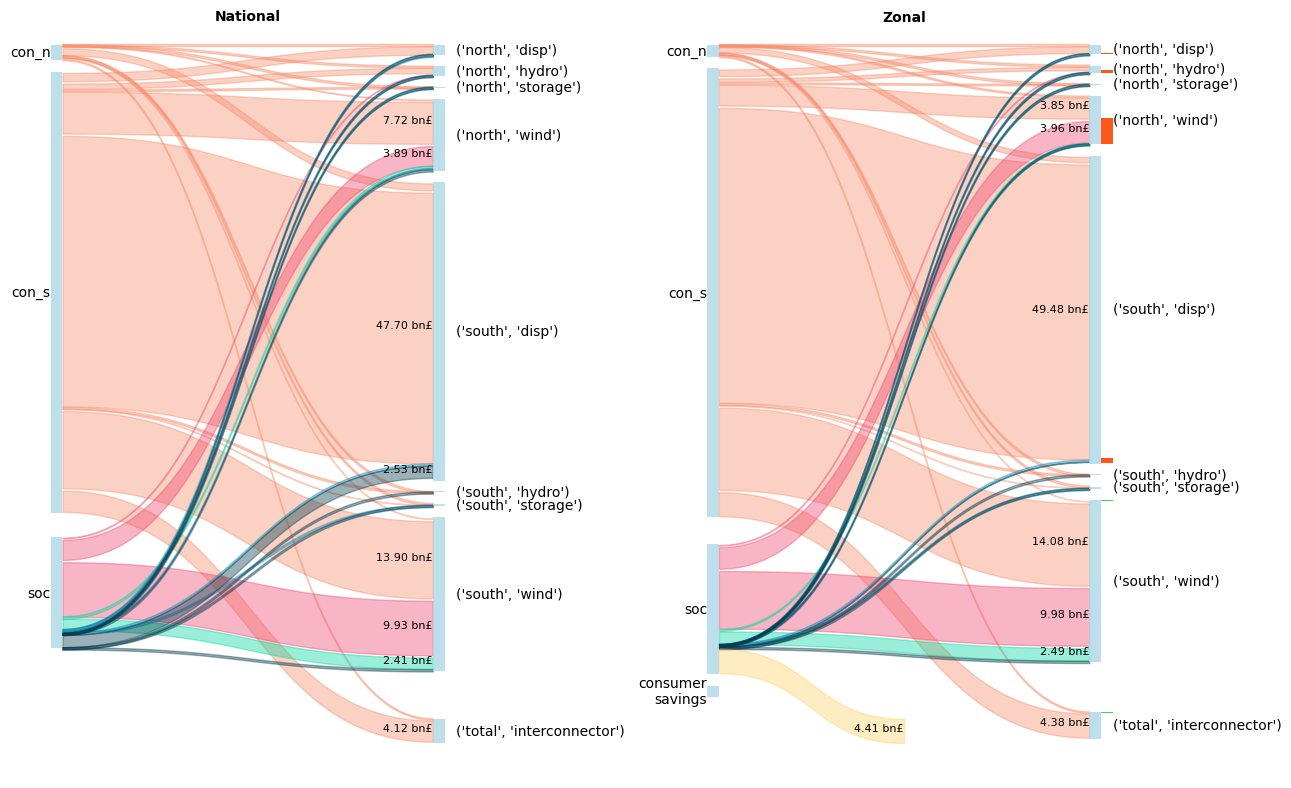

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 8))

alpha = 0.4

# def add_flow(ax, left_upper, right_upper, box_width, volume, tp=0.5):
def add_flow(
        ax,
        left_upper,
        right_upper,
        flow_vol,
        total,
        tp=0.5,
        color='r',
        text_threshold=0.02,
        end=None):

    start = (box_width, left_upper - flow_vol/2)

    if end is None:
        end = (1-box_width, right_upper - flow_vol/2)

    x, y = bezier_path(start, end, tp)

    prevent_overlap = 0.002
    ax.fill_between(x, y-flow_vol/2 + prevent_overlap, y+flow_vol/2 - prevent_overlap, alpha=alpha, color=color)

    if flow_vol > text_threshold:
        ax.text(
            x[-1],
            y[-1],
            f'{flow_vol*total:.2f} bn£',
            ha='right',
            fontsize=8
            )

for mode, ax in zip(['national', 'zonal'], axs):

    con_n, con_s, soc, rev_lowers, rev_uppers, rev_flows, rev_total = prepare_plot_data(mode)

    weight_north = (con_n[0] - con_n[1]) / (con_n[0] - con_n[1] + con_s[0] - con_s[1])
    weight_south = (con_s[0] - con_s[1]) / (con_n[0] - con_n[1] + con_s[0] - con_s[1])

    flowstarts = reset_flowstarts(rev_lowers, rev_uppers)

    for (region, carrier), flow in rev_flows.loc[idx[:, :, 'wholesale']].items():
        north_flow = flow * weight_north
        south_flow = flow * weight_south

        add_flow(
            ax,
            flowstarts['con_n'].add_flow(north_flow),
            flowstarts[(region, carrier)].add_flow(north_flow),
            north_flow,
            rev_total,
            color=color_mapper['wholesale']
            )

        add_flow(
            ax,
            flowstarts['con_s'].add_flow(south_flow),
            flowstarts[(region, carrier)].add_flow(south_flow),
            south_flow,
            rev_total,
            color=color_mapper['wholesale']
            )

    for factor, tp in zip(['roc', 'cfd', 'bids', 'offers'], [0.5, 0.5, 0.5, 0.5]):

        for (region, carrier), flow in rev_flows.loc[idx[:, :, factor]].items():

            if flow == 0:
                continue

            add_flow(
                ax,
                flowstarts['soc'].add_flow(flow),
                flowstarts[(region, carrier)].add_flow(flow),
                flow,
                rev_total,
                color=color_mapper[factor],
                tp=tp,
                )
    
    if mode == 'zonal':
        congestion_rent_flow = abs(costs.loc[idx['congestion_rent', :, 'zonal']].sum()) / rev_total

        add_flow(
            ax,
            flowstarts['soc'].add_flow(congestion_rent_flow),
            1,
            congestion_rent_flow,
            rev_total,
            color=color_mapper['congestion_rent'],
            end=(0.5, flowstarts['soc'].current_upper - 0.1)
            )


    for cost_party in ['con_n', 'con_s', 'soc']:

        ax.add_patch(plt.Rectangle((
            left_end,
            flowstarts[cost_party].current_upper),
            box_width,
            flowstarts[cost_party].upper_bound - flowstarts[cost_party].current_upper,
            facecolor='lightblue',
            alpha=0.8
            ))
        ax.text(
            0,
            flowstarts[cost_party].current_upper + (flowstarts[cost_party].upper_bound - flowstarts[cost_party].current_upper)/2,
            cost_party,
            ha='right',
            va='center'
            )

    if mode == 'zonal':
        ss = costs.loc[costs.index.get_level_values(0) != 'congestion_rent']

        cost_total = get_positive_cost_total(costs, 'zonal')

        saving_value = ss.loc[idx[:,:,'national']].sum() - ss.loc[idx[:,:,'zonal']].sum()

        saving_extent = saving_value / cost_total
        savings_upper = flowstarts[cost_party].current_upper - gap
        savings_lower = savings_upper - saving_extent

        ax.add_patch(plt.Rectangle((
            left_end,
            savings_lower),
            box_width,
            savings_upper - savings_lower,
            facecolor='lightblue',
            alpha=0.8
            ))
        ax.text(
            0,
            savings_lower + (savings_upper - savings_lower)/2,
            'consumer\nsavings',
            ha='right',
            va='center'
            )

    for lower, upper, name in zip(rev_lowers.values(), rev_uppers.values(), rev_lowers.keys()):

        min_height = 0.002
        height = max(upper-lower, min_height)

        ax.add_patch(plt.Rectangle((right_end - box_width, lower), box_width, height, facecolor='lightblue', alpha=0.8))

        ax.text(
            right_end + box_width,
            lower + (upper-lower)/2,
            name,
            ha='left',
            va='center'
            )
    ax.axis('off')
    ax.text(
        0.5,
        1.05,
        mode.capitalize(),
        ha='center',
        va='center',
        fontsize=10,
        weight='bold'
        )
    
    if mode == 'zonal':

        rev_diff = (rev_zonal - rev_national).groupby(level=[0,1]).sum().sort_values() / rev_total
        print(rev_diff)
        for (region, carrier), height in rev_diff.items():

            if height > 0:
                ax.add_patch(plt.Rectangle(
                    (right_end, flowstarts[region, carrier].upper_bound - height),
                    box_width,
                    height,
                    facecolor='limegreen',
                    alpha=0.9
                    ))
            else:
                ax.add_patch(plt.Rectangle(
                    (right_end, flowstarts[region, carrier].current_upper),
                    box_width,
                    abs(height),
                    facecolor='orangered',
                    alpha=0.9
                    ))




plt.tight_layout()
plt.savefig('money_flow.pdf')
plt.show()

In [156]:
flowstarts

{'con_n': FlowStart(upper_bound=1.0000, lower_bound=0.9789, current_upper=0.9796),
 'con_s': FlowStart(upper_bound=0.9589, lower_bound=0.1362, current_upper=0.1640),
 'soc': FlowStart(upper_bound=0.1162, lower_bound=-0.0776, current_upper=-0.1138),
 ('north',
  'disp'): FlowStart(upper_bound=1.0000, lower_bound=0.9838, current_upper=0.9839),
 ('north',
  'hydro'): FlowStart(upper_bound=0.9638, lower_bound=0.9506, current_upper=0.9506),
 ('north',
  'storage'): FlowStart(upper_bound=0.9306, lower_bound=0.9297, current_upper=0.9297),
 ('north',
  'wind'): FlowStart(upper_bound=0.9097, lower_bound=0.8242, current_upper=0.8243),
 ('south',
  'disp'): FlowStart(upper_bound=0.8042, lower_bound=0.2591, current_upper=0.2600),
 ('south',
  'hydro'): FlowStart(upper_bound=0.2391, lower_bound=0.2387, current_upper=0.2387),
 ('south',
  'storage'): FlowStart(upper_bound=0.2187, lower_bound=0.2146, current_upper=0.2146),
 ('south',
  'wind'): FlowStart(upper_bound=0.1946, lower_bound=-0.0921, curre

In [142]:
costs

wholesale        north       national     3.233213
                             zonal        2.481685
                 south       national    95.170288
                             zonal       96.558620
roc              socialised  national    13.905332
                             zonal       13.961020
cfd              socialised  national     1.969155
                             zonal        1.949835
bids             socialised  national     0.328954
                             zonal       -0.051858
offers           socialised  national     3.095382
                             zonal        0.476999
cfd              socialised  national     1.969155
                             zonal        1.949835
congestion_rent  socialised  national     0.000000
                             zonal       -4.412838
dtype: float64

In [104]:
ss.loc[idx[:,:,'national']].sum()

119.67147934634623

In [107]:
ss = costs.loc[costs.index.get_level_values(0) != 'congestion_rent']

print('national cost =')
print(ss.loc[idx[:,:,'national']].sum())
print('zonal cost =')
ss.loc[idx[:,:,'zonal']].sum()

national cost =
119.67147934634623
zonal cost =


117.32613672760715

In [24]:
rev_national.loc[idx[:,:,'roc']]

north  wind        5.065133
south  wind       18.948097
north  disp        0.000000
south  disp        0.000000
north  hydro       0.324936
south  hydro       0.000000
north  storage     0.000000
south  storage     0.000000
dtype: float64

In [26]:
rev_zonal.loc[idx[:,:,'roc']]

north  wind        5.147254
south  wind       18.948097
north  disp        0.000000
south  disp        0.000000
north  hydro       0.316099
south  hydro       0.000000
north  storage     0.000000
south  storage     0.000000
dtype: float64

In [147]:
rev_flows

north  disp            bids        -6.673064e-05
                       cfd          0.000000e+00
                       offers       1.998749e-13
                       roc          0.000000e+00
                       wholesale    3.891764e-02
       hydro           bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          3.726007e-03
                       wholesale    8.095866e-03
       storage         bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          0.000000e+00
                       wholesale    1.472167e-03
       wind            bids         0.000000e+00
                       cfd          1.191479e-04
                       offers       0.000000e+00
                       roc          8.637755e-03
                       wholesale    9.775753e-03
south  disp         

In [136]:
color_dict

{'wholesale': '#F78C6B',
 'wholesale selling': '#F78C6B',
 'wholesale buying': '#c3763c',
 'roc_payments': '#EF476F',
 'cfd_payments': '#06D6A0',
 'congestion_rent': '#FFD166',
 'offer_cost': '#073B4C',
 'bid_cost': '#118AB2'}

In [139]:
rev_zonal

north  wind            wholesale    4.323307e-01
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          5.269291e-03
                       roc          3.820029e-01
south  wind            wholesale    6.718664e+00
                       offers       0.000000e+00
                       bids         0.000000e+00
                       cfd          2.458216e+00
                       roc          8.149639e+00
north  disp            wholesale    1.721125e+00
                       offers       3.358307e-13
                       bids        -2.951149e-03
                       cfd          0.000000e+00
                       roc          0.000000e+00
south  disp            wholesale    1.809570e+01
                       offers       1.457364e-02
                       bids        -8.700657e-14
                       cfd          0.000000e+00
                       roc          0.000000e+00
north  hydro        

In [95]:
for _ in range(10):
    flowstarts['soc'].add_flow(0.1)
    print(flowstarts['soc'])

FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.0950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.1950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.2950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.3950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.4950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.5950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.6950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.7950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.8950)
FlowStart(upper_bound=0.2016, lower_bound=-0.0400, current_upper=-0.9950)


In [61]:
rev_national.sort_index(level=0)

north  disp            bids        -2.951149e-03
                       cfd          0.000000e+00
                       offers       8.839429e-12
                       roc          0.000000e+00
                       wholesale    1.721125e+00
       hydro           bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          1.647819e-01
                       wholesale    3.580380e-01
       storage         bids         0.000000e+00
                       cfd          0.000000e+00
                       offers       0.000000e+00
                       roc          0.000000e+00
                       wholesale    6.510627e-02
       wind            bids         0.000000e+00
                       cfd          5.269291e-03
                       offers       0.000000e+00
                       roc          3.820029e-01
                       wholesale    4.323307e-01
south  disp         

In [166]:
rev_uppers

{('north', 'wind'): 1,
 ('north', 'disp'): 0.6373634114479054,
 ('north', 'hydro'): 0.616861272342654,
 ('north', 'storage'): 0.5858894748202965,
 ('south', 'wind'): 0.5647625529746111,
 ('south', 'disp'): 0.1618262638915575,
 ('south', 'hydro'): -0.08766582736524565,
 ('south', 'storage'): -0.10787788701136596,
 ('total', 'interconnector'): -0.13217607451181007}

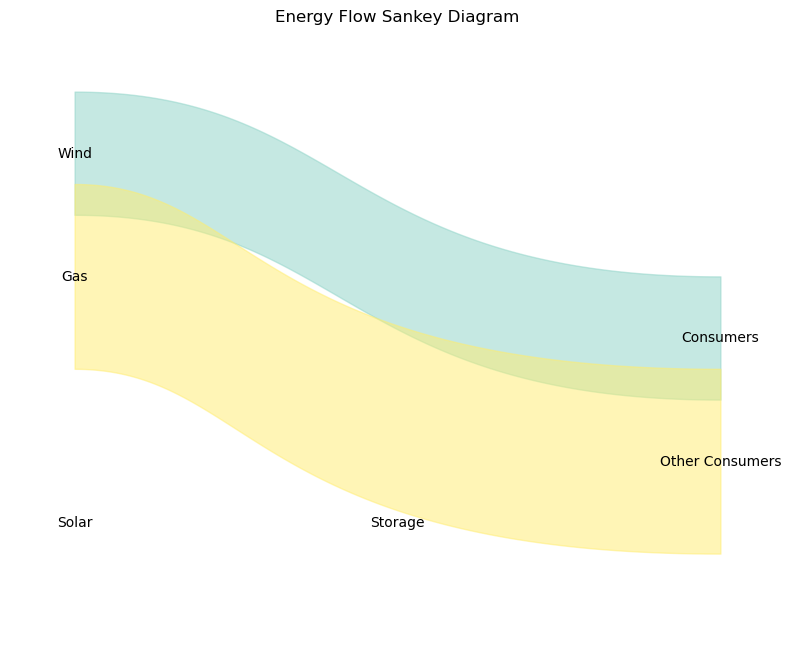

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create example Sankey data
nodes = ['Wind', 'Gas', 'Solar', 'Consumers', 'Storage']
flows = [
    ('Wind', 'Consumers', 0.2),
    ('Gas', 'Other Consumers', 0.3),
    # ('Solar', 'Storage', 20),
    # ('Storage', 'Consumers', 15),
]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set node positions
node_pos = {
    'Wind': (0, 0.8),
    'Gas': (0, 0.6), 
    'Solar': (0, 0.2),
    'Storage': (0.5, 0.2),
    'Consumers': (1, 0.5),
    'Other Consumers': (1, 0.3)
}

# Draw flows
colors = plt.cm.Set3(np.linspace(0, 1, len(flows)))

for (source, target, value), color in zip(flows, colors):

    r = np.random.rand() * 0.5
    x, y = bezier_path(node_pos[source], node_pos[target], r)

    ax.fill_between(x, y-value/2, y+value/2, alpha=0.5, color=color)

# Draw nodes
for node, (x, y) in node_pos.items():
    ax.text(x, y, node, ha='center', va='center')

# Configure plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Energy Flow Sankey Diagram')

# plt.savefig('dummy_sankey.pdfk')
plt.show()

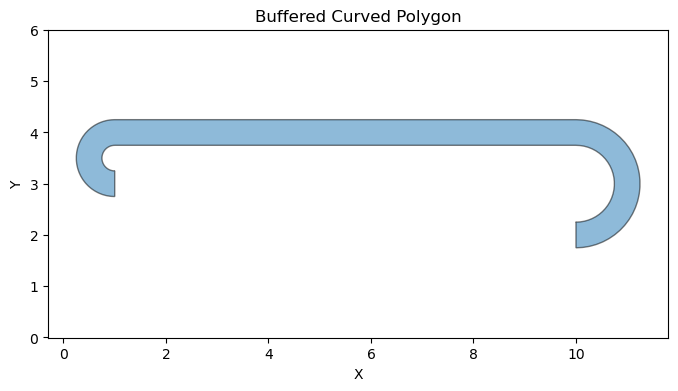

In [ ]:

# Example usage:
if __name__ == '__main__':
    start = (1, 3)
    end = (10, 2)
    buffer_distance = 0.5  # How much to buffer (i.e. the “thickness” around the curve)
    height = 4
    
    poly = create_curved_polygon(start, end, height, buffer_distance, resolution=30)
    
    # Plotting the buffered polygon:
    xs, ys = poly.exterior.xy
    plt.figure(figsize=(8, 4))
    plt.fill(xs, ys, alpha=0.5, edgecolor='k')
    plt.title('Buffered Curved Polygon')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
